In [6]:
from pyquil.quil import Program
from pyquil.gates import H, RX, MEASURE, RZ, CPHASE, CNOT
from pyquil.api import get_qc
import numpy as np
from new_noise import add_noise_to_program
import matplotlib.pyplot as plt
from Calibrations import Calibrations

Adiabatic shift

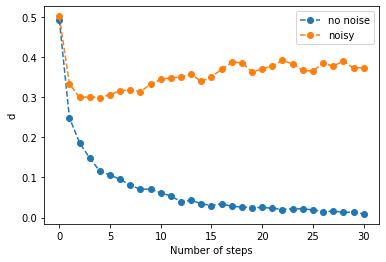

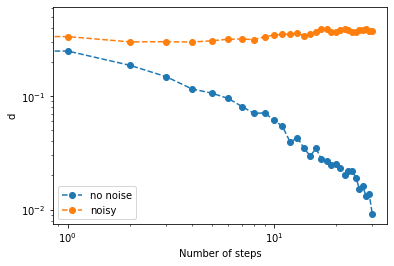

In [4]:
def adiabatic_shift(qc, qubits, steps, numshots, noise=False, cal=None):
    p = Program()
    for i in range(qubits):
        p += H(i)

    angles=(np.pi/2)*np.array(range(1,steps+1))/(steps+1)
    for theta in angles:
        alpha = -np.cos(theta)
        beta = -np.sin(theta)
        for i in range(qubits-1) :
            p += RZ(beta,i)
            p += RZ(beta,i+1)
            p += CPHASE(-2*beta,i,i+1)
        for i in range(qubits):
            p += RX(alpha, i)

    p.declare('ro', 'BIT', qubits)
    for i in range(qubits):
        p += MEASURE(i, ("ro", i))
    p.wrap_in_numshots_loop(numshots)
    if noise:
        if cal is not None:
            p = add_noise_to_program(qc, p, convert_to_native=False, calibrations=cal)
        else:
            p = add_noise_to_program(qc, p, convert_to_native=False)
    bitstrings = qc.run(p).readout_data.get("ro")
    d = 0
    for i in bitstrings:
        for q in range(qubits-1):
            d += (i[q] != i[q+1])
    d /= numshots*(qubits-1)
    return d

def plot_results(no_noise, noisy, log=False):
    plt.plot(no_noise,linestyle='--', marker='o', label='no noise')
    plt.plot(noisy,linestyle='--', marker='o', label='noisy')
    plt.xlabel('Number of steps')
    plt.ylabel('d')
    plt.legend()
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.show()

def run_experiment(qubits, numshots, maxN):
    # qc = get_qc(str(qubits) + 'q-qvm')
    qc = get_qc('Aspen-M-3', as_qvm=True, execution_timeout=1000)
    cal = Calibrations(qc)
    no_noise = np.zeros(maxN)
    noisy = np.zeros(maxN)
    for i in range (maxN):
        no_noise[i] = adiabatic_shift(qc, qubits=qubits, steps=i, numshots=numshots, noise=False)
        noisy[i] = adiabatic_shift(qc, qubits=qubits, steps=i, numshots=numshots, noise=True, cal=cal)
    return no_noise, noisy

no_noise, noisy = run_experiment(8,500,31)
plot_results(no_noise, noisy)
plot_results(no_noise, noisy, log=True)

GHZ

DECLARE ro BIT[3]
H 0
CNOT 0 1
CNOT 1 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



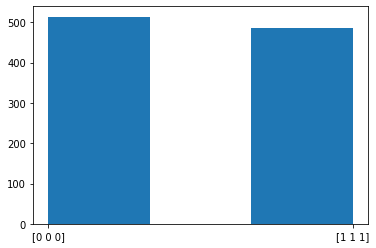

(array([268.,  30., 312., 123.,  49.,  58.,  42., 118.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

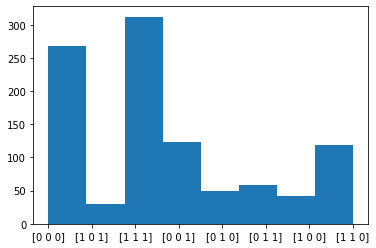

In [29]:

ghz_prog = Program()
ghz_prog.declare("ro", "BIT", 3)
ghz_prog += H(0)
ghz_prog += CNOT(0, 1)
ghz_prog += CNOT(1, 2)
ghz_prog += MEASURE(0, ("ro", 0))
ghz_prog += MEASURE(1, ("ro", 1))
ghz_prog += MEASURE(2, ("ro", 2))
ghz_prog.wrap_in_numshots_loop(1000)
print(ghz_prog)
qc = get_qc('Aspen-M-2', as_qvm=True, execution_timeout=1000)
no_noise = qc.run(ghz_prog).readout_data.get("ro")
plt.hist([np.array2string(i) for i in no_noise], bins=3)
plt.show()
p = add_noise_to_program(qc, ghz_prog, convert_to_native=True)
noisy = qc.run(p).readout_data.get("ro")
plt.hist([np.array2string(i) for i in noisy], bins=8)
